# Imports and setup

In [1]:
import pandas as pd 
import numpy as np
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Tells matplotlib to use the notebook backend
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150

# Utility functions

In [2]:
def create_submission_file(predictions, model_name):
    num_preds = len(predictions)
    
    if num_preds != 3926:
        print("Number of predictions not equal to number of test observations!")
    
    pd.DataFrame({
        "Prediction" : predictions,
        "Id" : range(1, num_preds + 1)
    }).to_csv(model_name + ".csv", index=False)
    
def accuracy(predictions, truth):
    return np.mean(predictions == truth)

# Load the data and split into training and validation sets

In [3]:
# note: these datasets are slightly modified from the provided data
# the train set includes the "activity" column, and both datasets have column names
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# FOR THE SAKE OF THE WORKSHOP: USE A SMALLER TRAINING SET SO THINGS RUN FASTER
# FOR COMPETITION ENTRIES, REMOVE THIS SO YOU USE ALL THE TRAINING DATA
train = train.loc[1:500, :]

y = train["activity"]
X = train.iloc[:, train.columns != "activity"]

# could split the data manually if you wanted:

# msk = np.random.rand(len(train)) < 0.8

# X_train = X[msk]
# y_train = y[msk]
# X_val = X[~msk]
# y_val = y[~msk]

# or use provided code
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Train models with different hyperparameters on the training set and evaluate on the validation set

In [4]:
for k in [5, 10, 15]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    
    report = "k: " + str(k) + " gives validation accuracy: " + str(accuracy(preds, y_val))
    print(report)

k: 5 gives validation accuracy: 0.87
k: 10 gives validation accuracy: 0.87
k: 15 gives validation accuracy: 0.86


We see that the best value of K is 5. In practice, we want to do this for a bunch of train/validation splits, so we use cross-validation. In practice, it's also better to search for the best k by picking k randomly. Here's some code that automatically searches for the best k using cross validation.

In [5]:
# pick k randomly in the range [1, 30]
# note that for the competition there are a number of other useful hyperparameters worth exploring
# in particular the precise metric, and whether votes are weighed by distance
param_dist = {
    'n_neighbors': sp_randint(1, 31),
}

clf = neighbors.KNeighborsClassifier()

# now try 10 random k and save the best
clf_rs = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_iter=10, n_jobs = -1)

# now clf_rs is just a KNN model with the best value of k automatically selected
# give the randomized search the entire training set, it'll do cross validation internally
clf_rs.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0d19ce09b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

See the results of the cross-validated search for k. Also assess performance on the validation set.

In [6]:
knn_cv_results = pd.DataFrame(clf_rs.cv_results_)
knn_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.016230,0.087832,0.750,0.919995,8,{'n_neighbors': 8},10,0.802395,0.924925,0.760479,0.909910,0.686747,0.925150,0.006835,0.002108,0.047769,0.007132
1,0.013079,0.101006,0.768,0.878987,20,{'n_neighbors': 20},5,0.784431,0.864865,0.790419,0.879880,0.728916,0.892216,0.004433,0.015069,0.027662,0.011184
2,0.009590,0.108903,0.758,0.918997,11,{'n_neighbors': 11},9,0.772455,0.933934,0.784431,0.900901,0.716867,0.922156,0.000093,0.021404,0.029408,0.013669
3,0.009389,0.127352,0.772,0.875987,27,{'n_neighbors': 27},2,0.760479,0.858859,0.802395,0.879880,0.753012,0.889222,0.000222,0.058474,0.021739,0.012698
4,0.020264,0.125665,0.772,0.875987,27,{'n_neighbors': 27},2,0.760479,0.858859,0.802395,0.879880,0.753012,0.889222,0.007116,0.009466,0.021739,0.012698
5,0.009979,0.093821,0.768,0.929001,9,{'n_neighbors': 9},5,0.796407,0.924925,0.790419,0.933934,0.716867,0.928144,0.000894,0.006748,0.036131,0.003728
6,0.009382,0.091491,0.774,0.871992,22,{'n_neighbors': 22},1,0.796407,0.846847,0.802395,0.888889,0.722892,0.880240,0.000207,0.006454,0.036114,0.018127
7,0.014453,0.138022,0.766,0.866963,30,{'n_neighbors': 30},8,0.760479,0.852853,0.778443,0.843844,0.759036,0.904192,0.007267,0.033253,0.008831,0.026580
8,0.035494,0.138644,0.770,0.932001,7,{'n_neighbors': 7},4,0.802395,0.927928,0.784431,0.936937,0.722892,0.931138,0.014554,0.017127,0.034012,0.003728
9,0.025117,0.162094,0.768,0.878987,20,{'n_neighbors': 20},5,0.784431,0.864865,0.790419,0.879880,0.728916,0.892216,0.007687,0.017508,0.027662,0.011184


Finally, predict on the text set and save the 

In [7]:
preds = clf_rs.predict(test)
create_submission_file(preds, "knn_tuned_predictions")

Let's visualize the cross-validation results

In [8]:
cv_results = knn_cv_results[['param_n_neighbors', 
                             'mean_test_score', 
                             'mean_train_score']
                            ].sort_values(by = 'param_n_neighbors')

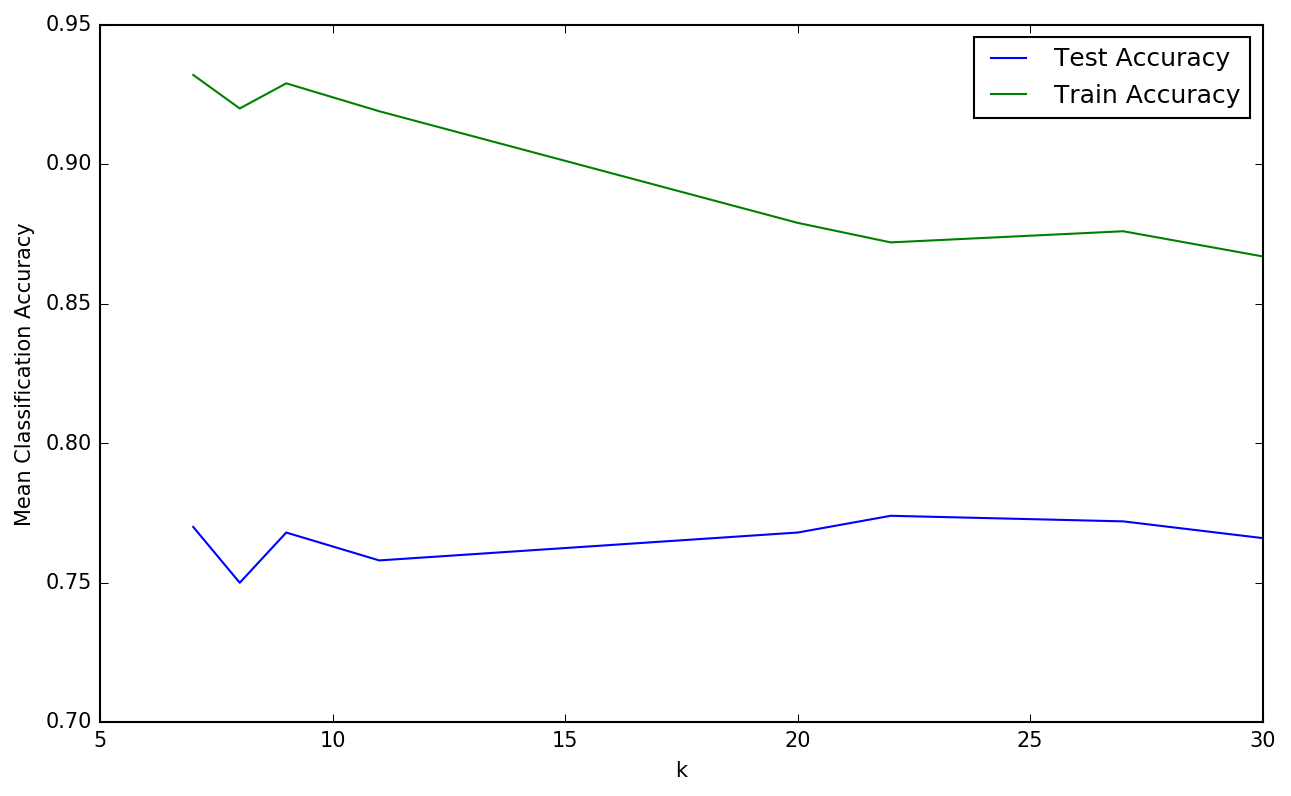

In [9]:
plt.plot(cv_results.param_n_neighbors, 
         cv_results.mean_test_score,
         label = 'Test Accuracy')
plt.plot(cv_results.param_n_neighbors, 
         cv_results.mean_train_score,
         label = 'Train Accuracy')

plt.xlabel('k')
plt.ylabel('Mean Classification Accuracy')
plt.legend(loc = 'upper right')

plt.show()

# Some sample code for grid search on a support vector machine for classification

In [10]:
# in practice you will want to try much broader ranges of hyperparameters than this
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_clf = GridSearchCV(SVC(), tuned_parameters)
svm_clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Again we check how well we did

In [11]:
pd.DataFrame(svm_clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,param_kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.093854,0.043248,0.658,0.776013,1,0.001,rbf,"{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}",11,0.682635,0.780781,0.700599,0.783784,0.590361,0.763473,0.006969,0.000861,0.048246,0.008951
1,0.144235,0.044135,0.378,0.379997,1,0.0001,rbf,"{'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}",12,0.383234,0.378378,0.383234,0.378378,0.367470,0.383234,0.002371,0.000436,0.007424,0.002289
2,0.064199,0.035011,0.900,0.992007,10,0.001,rbf,"{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}",9,0.856287,0.996997,0.964072,0.993994,0.879518,0.985030,0.004116,0.000885,0.046353,0.005084
3,0.084106,0.043139,0.688,0.813002,10,0.0001,rbf,"{'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}",10,0.688623,0.819820,0.754491,0.807808,0.620482,0.811377,0.001523,0.000439,0.054683,0.005037
4,0.071289,0.037472,0.908,1.000000,100,0.001,rbf,"{'kernel': 'rbf', 'C': 100, 'gamma': 0.001}",1,0.868263,1.000000,0.934132,1.000000,0.921687,1.000000,0.008432,0.003649,0.028595,0.000000
5,0.065014,0.035325,0.902,0.991006,100,0.0001,rbf,"{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}",8,0.856287,0.993994,0.964072,0.993994,0.885542,0.985030,0.002591,0.001307,0.045549,0.004226
6,0.079296,0.039587,0.908,1.000000,1000,0.001,rbf,"{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}",1,0.868263,1.000000,0.934132,1.000000,0.921687,1.000000,0.009599,0.002290,0.028595,0.000000
7,0.071632,0.039573,0.908,1.000000,1000,0.0001,rbf,"{'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}",1,0.862275,1.000000,0.934132,1.000000,0.927711,1.000000,0.014147,0.007922,0.032486,0.000000
8,0.062308,0.034423,0.908,1.000000,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",1,0.862275,1.000000,0.934132,1.000000,0.927711,1.000000,0.004105,0.003383,0.032486,0.000000
9,0.058321,0.031756,0.908,1.000000,10,NaN,linear,"{'C': 10, 'kernel': 'linear'}",1,0.862275,1.000000,0.934132,1.000000,0.927711,1.000000,0.004747,0.001763,0.032486,0.000000


In [12]:
preds = svm_clf.predict(test)
create_submission_file(preds, "svm_tuned_predictions")